In [ ]:
# NEXT STEPS: g2 way to slow!!

#1) compare vertex, cga n_b = 2000, and published solvent effects phase diagrams (use ImageJ) -> any discrepancy w cga? fix
#     -> make cga faster? cut down run time, run on tower!!

# conclusions: 
#             - vertex matches solvent effects
#             - cga acurancy depends on n_b -> kappa approximation
#             - cga slightly underestiamtes cylindrical stabilty

#2) represent square-cylindrical phsae as orderparameter (critical wavevectors) -> find gamma 3, gamma 4 constants

#3) Develop bead mutagenesis code 

### procedure: 
- find q*, 
- represent phases of interest in terms of q*
- evaluate gammas at q*,
- minimize wrt amplitude, 
- compare 

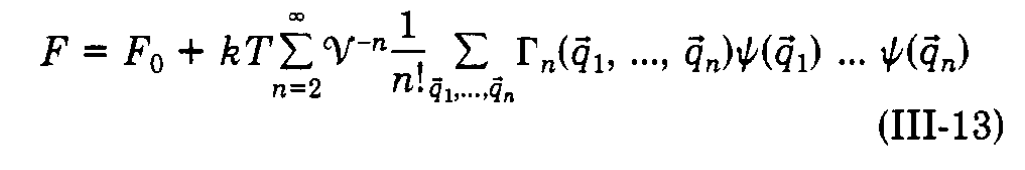

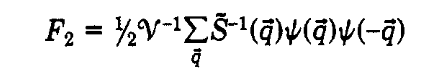

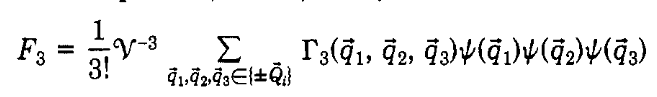

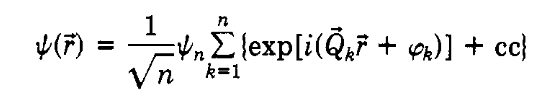

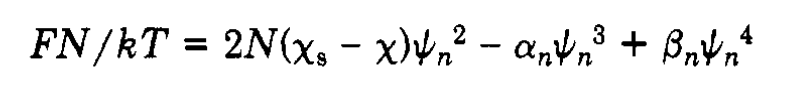

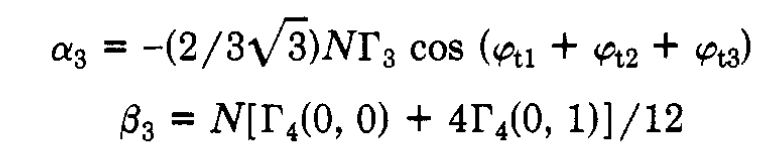

# Vertex (Greens functions)

In [1]:
import sys
sys.path.append("./vertex_subroutines")
from GAMcalc import *  # Code for calculating vertex functions
import propagator  # propagator object used to store pre-calculated values
import wignerD as wd # wigner D object used to store pre-calculated values

In [ ]:
import importlib
from cga import *
#import cga

In [ ]:
#from cga import *
import cga
import GAMcalc
importlib.reload(cga)
importlib.reload(GAMcalc)

In [2]:
pset=propagator.prop_set(nlam=10) 
wigset = wd.wigner_d_vals()

In [ ]:
q_star = 1
N = 10
FA = 0.5
lam_q = q_star*np.array([1, 0, 0])
    
lam_q_2 = q_star*np.array([2, 0, 0])
#gamma3(pset, N, FA, np.array([lam_q, lam_q, -lam_q_2]))

In [ ]:
cyl_q1 = q_star*np.array([1, 0, 0])
cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
#gamma3(pset, N, FA, cyl_qs)

In [ ]:
cyl_q1_2 = q_star*np.array([0, np.sqrt(3), 0])
cyl_q2_2 = 0.5*q_star*np.array([3, -np.sqrt(3), 0])
cyl_q3_2 = 0.5*q_star*np.array([-3, -np.sqrt(3), 0])
cyl_qs_2 = np.array([cyl_q1_2, cyl_q2_2, cyl_q3_2])

gamma4(pset, wigset, N, FA, np.array([cyl_q1_2, -cyl_q1_2, cyl_q2_2, -cyl_q2_2]))

In [ ]:
%%time
#SINGLE WAVEMODE PHASE DIAGRAM
N = 100000
fa_array = [0.3, 0.35, 0.4, 0.45, 0.5]#np.arange(0.2, 0.51, .02)
chi_array = np.arange(10, 13, 0.1)/N#np.arange(5, 30, 0.5)/N #np.array([5, 7, 10, 12, 15, 17, 20])/N #* N
cyl_pnts = np.array([])
lam_pnts = np.array([])
dis_pnts = np.array([])

for FA in fa_array:
    KS = spinodal(pset, N, FA)
    q_star = KS[0]

    cyl_q1 = q_star*np.array([1, 0, 0])
    cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
    cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
    cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])

    lam_q = q_star*np.array([1, 0, 0])
    
    lam_g3 = 0
    
    cyl_g3 = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3(pset, N, FA, cyl_qs)
    
    lam_g4 = (1/24) * (6) * (1) * gamma4(pset, wigset, N, FA, np.array([lam_q, -lam_q, lam_q, -lam_q]))
    
    cyl_g4 = (1/12)* (gamma4(pset, wigset, N, FA, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ])) + \
              4*gamma4(pset, wigset, N, FA, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])))
    for CHI in chi_array:
        lam_g2 = (1/2) * 2 * (1) * gamma2(pset, N, FA, q_star, CHI)                
        
        cyl_g2 = (1/2) * 6 * (1/3) * gamma2(pset, N, FA, q_star, CHI) 
        
        amp_l1 = optimize.fmin(lambda amps: np.real(amps**2 * lam_g2 + amps**3 * lam_g3 + amps**4 * lam_g4), \
                              1, disp=False)
        amp_c1 = optimize.fmin(lambda amps: np.real(amps**2 * cyl_g2 + amps**3 * cyl_g3 + amps**4 * cyl_g4), \
                              1, disp=False)
        
        lamF = amp_l1**2 * lam_g2 + amp_l1**3 * lam_g3 + amp_l1**4 * lam_g4 
        
        cylF = amp_c1**2 * cyl_g2 + amp_c1**3 * cyl_g3 + amp_c1**4 * cyl_g4 
        
        
        point = np.array([FA, CHI*N])
        if (lamF > 0 and cylF > 0):
            #disordered stable
            dis_pnts = np.append(dis_pnts, point)
        elif (lamF < cylF):
            lam_pnts = np.append(lam_pnts, point) 
        else:
            cyl_pnts = np.append(cyl_pnts, point)
            
    print("one FA done!!")
            

In [ ]:
%%time
# TWO HARMONICS PHASE DIAGRAM
N = 100
fa_array = [0.3, 0.35, 0.4, 0.45, 0.5]#np.arange(0.2, 0.51, .02)
chi_array = np.arange(10, 13, 0.1)/N#np.arange(5, 30, 0.5)/N #np.array([5, 7, 10, 12, 15, 17, 20])/N #* N
cyl_pnts = np.array([])
lam_pnts = np.array([])
gyr_pnts = np.array([])
dis_pnts = np.array([])

for FA in fa_array:
    KS = spinodal(pset, N, FA)
    q_star = KS[0]

    
    lam_q = q_star*np.array([1, 0, 0])
    
    lam_q_2 = q_star*np.array([2, 0, 0])
    
    
    cyl_q1 = q_star*np.array([1, 0, 0])
    cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
    cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
    cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
    
    cyl_q1_2 = q_star*np.array([0, np.sqrt(3), 0])
    cyl_q2_2 = 0.5*q_star*np.array([3, -np.sqrt(3), 0])
    cyl_q3_2 = 0.5*q_star*np.array([-3, -np.sqrt(3), 0])
    cyl_qs_2 = np.array([cyl_q1_2, cyl_q2_2, cyl_q3_2])
    
    
    sq_6 = round((1/np.sqrt(6)) * q_star, 7)
    gyr_q1 = sq_6*np.array([-1, 2, 1])
    gyr_q2 = sq_6*np.array([2, 1, -1])
    gyr_q3 = sq_6*np.array([1, -1, 2])
    gyr_q4 = sq_6*np.array([2, -1, -1])
    gyr_q5 = sq_6*np.array([-1, 2, -1])
    gyr_q6 = sq_6*np.array([-1, -1, 2])
    
    gyr_q7 = sq_6*np.array([2, 1, 1])
    gyr_q8 = sq_6*np.array([1, 2, 1])
    gyr_q9 = sq_6*np.array([1, 1, 2])
    gyr_q10 = sq_6*np.array([2, -1, 1])
    gyr_q11 = sq_6*np.array([1, 2, -1])
    gyr_q12 = sq_6*np.array([-1, 1, 2])
    
    gyr_q1_2 = sq_6*np.array([2, 2, 0])
    gyr_q2_2 = sq_6*np.array([2, 0, 2])
    gyr_q3_2 = sq_6*np.array([0, 2, 2])
    gyr_q4_2 = sq_6*np.array([-2, 2, 0])
    gyr_q5_2 = sq_6*np.array([-2, 0, 2])
    gyr_q6_2 = sq_6*np.array([0, -2, 2])
    
    
    lam_g3 = 0
    lam_g3_2 = 0
    lam_g3_mix = (1/6) * (1) * 2 * gamma3(pset, N, FA, np.array([lam_q, lam_q, -lam_q_2]))
    
    cyl_g3 = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3(pset, N, FA, cyl_qs)
    cyl_g3_2 = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3(pset, N, FA, cyl_qs_2)
    cyl_g3_mix = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3(pset, N, FA, np.array([-cyl_q2_2, -cyl_q2, cyl_q1]))
    
    gyr_g3 = (1/6) * (1/(12*np.sqrt(12))) * 48 * gamma3(pset, N, FA, np.array([gyr_q7, -gyr_q11, -gyr_q3]))
    gyr_g3_2 = (1/6) * (1/(6*np.sqrt(6))) * 48 * gamma3(pset, N, FA, np.array([gyr_q1_2, -gyr_q3_2, gyr_q5_2])) # 6 OR 12???
    gyr_g3_mix = (1/6) * (1/(12*np.sqrt(6))) * 12 * gamma3(pset, N, FA, np.array([gyr_q7, -gyr_q4, -gyr_q3_2]))
    
    lam_g4 = (1/24) * (6) * (1) * gamma4(pset, wigset, N, FA, np.array([lam_q, -lam_q, lam_q, -lam_q]))
    lam_g4_2 = (1/24) * (6) * (1) * gamma4(pset, wigset, N, FA, np.array([lam_q_2, -lam_q_2, lam_q_2, -lam_q_2]))
    lam_g4_mix = (1/24) * (4) * (1) * gamma4(pset, wigset, N, FA, np.array([lam_q, -lam_q, lam_q_2, -lam_q_2]))
    
    cyl_g4 = (1/12)* (gamma4(pset, wigset, N, FA, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ])) + \
              4*gamma4(pset, wigset, N, FA, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])))
    cyl_g4_2 = (1/12)* (gamma4(pset, wigset, N, FA, np.array([cyl_q1_2 , -cyl_q1_2 , cyl_q1_2 , -cyl_q1_2 ])) + \
              4*gamma4(pset, wigset, N, FA, np.array([cyl_q1_2, -cyl_q1_2, cyl_q2_2, -cyl_q2_2])))
    cyl_g4_mix1 = (1/3) * (2*gamma4(pset, wigset, N, FA, np.array([-cyl_q3_2, cyl_q3, -cyl_q2, -cyl_q2_2])) + \
                           3*gamma4(pset, wigset, N, FA, np.array([cyl_q2_2, -cyl_q2_2, -cyl_q3, cyl_q3])) + \
                           2*gamma4(pset, wigset, N, FA, np.array([cyl_q1, -cyl_q1, -cyl_q3_2, cyl_q3_2])))
    cyl_g4_mix2 = (1/3) * gamma4(pset, wigset, N, FA, np.array([cyl_q2_2, cyl_q2, cyl_q2, cyl_q3]))
    
    gyr_g4 = (1/48) * (gamma4(pset, wigset, N, FA, np.array([gyr_q1, -gyr_q1, gyr_q1, -gyr_q1])) + \
                       4*gamma4(pset, wigset, N, FA, np.array([gyr_q7, -gyr_q7, gyr_q8, -gyr_q8])) + \
                       4*gamma4(pset, wigset, N, FA, np.array([gyr_q7, -gyr_q7, gyr_q10, -gyr_q10])) + \
                       4*gamma4(pset, wigset, N, FA, np.array([gyr_q7, -gyr_q7, gyr_q11, -gyr_q11])) + \
                       2*gamma4(pset, wigset, N, FA, np.array([gyr_q7, -gyr_q7, gyr_q4, -gyr_q4])) + \
                       8*gamma4(pset, wigset, N, FA, np.array([gyr_q7, -gyr_q7, gyr_q12, -gyr_q12])) + \
                       -4*gamma4(pset, wigset, N, FA, np.array([gyr_q1, gyr_q4, -gyr_q10, -gyr_q5])) + \
                       2*gamma4(pset, wigset, N, FA, np.array([gyr_q7, -gyr_q2, gyr_q4, -gyr_q10])) + \
                       -4*gamma4(pset, wigset, N, FA, np.array([gyr_q1, -gyr_q5, -gyr_q7, gyr_q2])))
    
    gyr_g4_2 = (1/24) * (gamma4(pset, wigset, N, FA, np.array([gyr_q1_2, -gyr_q1_2, gyr_q1_2, -gyr_q1_2])) + \
                       8*gamma4(pset, wigset, N, FA, np.array([gyr_q1_2, -gyr_q1_2, gyr_q2_2, -gyr_q2_2])) + \
                       2*gamma4(pset, wigset, N, FA, np.array([gyr_q1_2, -gyr_q1_2, gyr_q4_2, -gyr_q4_2])) + \
                       2*gamma4(pset, wigset, N, FA, np.array([gyr_q1_2, -gyr_q2_2, gyr_q5_2, -gyr_q4_2])))

    gyr_g4_mix1 = (1/6) * (2*gamma4(pset, wigset, N, FA, np.array([gyr_q1, -gyr_q1, gyr_q4_2, -gyr_q4_2])) + \
                           2*gamma4(pset, wigset, N, FA, np.array([gyr_q1, -gyr_q1, gyr_q1_2, -gyr_q1_2])) + \
                           -2*gamma4(pset, wigset, N, FA, np.array([gyr_q1, -gyr_q4_2, gyr_q11, -gyr_q1_2])) + \
                           gamma4(pset, wigset, N, FA, np.array([gyr_q1, -gyr_q4_2, gyr_q1, -gyr_q3_2])) + \
                           -2*gamma4(pset, wigset, N, FA, np.array([gyr_q1, -gyr_q4_2, -gyr_q6_2, -gyr_q11])) + \
                           gamma4(pset, wigset, N, FA, np.array([gyr_q7, -gyr_q7, gyr_q6_2, -gyr_q6_2])) + \
                           gamma4(pset, wigset, N, FA, np.array([gyr_q7, -gyr_q7, gyr_q3_2, -gyr_q3_2])))
    
    gyr_g4_mix2 = (1/3) * (2*gamma4(pset, wigset, N, FA, np.array([gyr_q1, -gyr_q4_2, -gyr_q2, -gyr_q6])) + \
                           -1*gamma4(pset, wigset, N, FA, np.array([gyr_q7, -gyr_q8, gyr_q3_2, -gyr_q9])) + \
                           -1*gamma4(pset, wigset, N, FA, np.array([gyr_q8, -gyr_q3_2, -gyr_q7, gyr_q9])))  # WRONG
    for CHI in chi_array:
        lam_g2 = (1/2) * 2 * (1) * gamma2(pset, N, FA, q_star, CHI)
        lam_g2_2 = (1/2) * 2 * (1) * gamma2(pset, N, FA, 2*q_star, CHI)                 
        
        cyl_g2 = (1/2) * 6 * (1/3) * gamma2(pset, N, FA, q_star, CHI) 
        cyl_g2_2 = (1/2) * 6 * (1/3) * gamma2(pset, N, FA, np.sqrt(3)*q_star, CHI) 
        
        gyr_g2 = (1/2) * 24 * (1/12) * gamma2(pset, N, FA, q_star, CHI)
        gyr_g2_2 = (1/2) * 12 * (1/6) * gamma2(pset, N, FA, np.sqrt(4/3)*q_star, CHI) 
        
        amp_l1, amp_l2 = optimize.fmin(lambda amps: np.real(amps[0]**2 * lam_g2 + amps[0]**3 * lam_g3 + amps[0]**4 * lam_g4 + \
                                                        amps[1]**2 * lam_g2_2 + amps[1]**3 * lam_g3_2 + amps[1]**4 * lam_g4_2 + \
                                                        amps[0]**2 * amps[1] * lam_g3_mix + amps[0]**2 * amps[1]**2 * lam_g4_mix), \
                              [1,1], disp=False)
        
        amp_c1, amp_c2 = optimize.fmin(lambda amps: np.real(amps[0]**2 * cyl_g2 + amps[0]**3 * cyl_g3 + amps[0]**4 * cyl_g4 + \
                                                 amps[1]**2 * cyl_g2_2 + amps[1]**3 * cyl_g3_2 + amps[1]**4 * cyl_g4_2 + \
                                                 amps[0]**2 * amps[1] * cyl_g3_mix + amps[0]**2 * amps[1]**2 * cyl_g4_mix1 + \
                                                 amps[0]**3 * amps[1] * cyl_g4_mix2), \
                              [1,1], disp=False)
        
        amp_g1, amp_g2 = optimize.fmin(lambda amps: np.real(amps[0]**2 * gyr_g2 + amps[0]**3 * gyr_g3 + amps[0]**4 * gyr_g4 + \
                                                 amps[1]**2 * gyr_g2_2 + amps[1]**3 * gyr_g3_2 + amps[1]**4 * gyr_g4_2 + \
                                                 amps[0]**2 * amps[1] * gyr_g3_mix + amps[0]**2 * amps[1]**2 * gyr_g4_mix1 + \
                                                 amps[0]**3 * amps[1] * gyr_g4_mix2), \
                              [1,1], disp=False)

        lamF = amp_l1**2 * lam_g2 + amp_l1**3 * lam_g3 + amp_l1**4 * lam_g4 + \
                amp_l2**2 * lam_g2_2 + amp_l2**3 * lam_g3_2 + amp_l2**4 * lam_g4_2 +\
                amp_l1**2 * amp_l2 * lam_g3_mix + amp_l1**2 * amp_l2**2 * lam_g4_mix
        
        cylF = amp_c1**2 * cyl_g2 + amp_c1**3 * cyl_g3 + amp_c1**4 * cyl_g4 +\
                amp_c2**2 * cyl_g2_2 + amp_c2**3 * cyl_g3_2 + amp_c2**4 * cyl_g4_2 + \
                amp_c1**2 * amp_c2 * cyl_g3_mix + amp_c1**2 * amp_c2**2 * cyl_g4_mix1 +\
                amp_c1**3 * amp_c2 * cyl_g4_mix2
        
        gyrF = amp_g1**2 * gyr_g2 + amp_g1**3 * gyr_g3 + amp_g1**4 * gyr_g4 +\
                amp_g2**2 * gyr_g2_2 + amp_g2**3 * gyr_g3_2 + amp_g2**4 * gyr_g4_2 + \
                amp_g1**2 * amp_g2 * gyr_g3_mix + amp_g1**2 * amp_g2**2 * gyr_g4_mix1 +\
                amp_g1**3 * amp_g2 * gyr_g4_mix2

        point = np.array([FA, CHI*N])
        if (lamF > 0 and cylF > 0 and gyrF > 0):
            #disordered stable
            dis_pnts = np.append(dis_pnts, point)
        elif (lamF < cylF and lamF < gyrF):
            lam_pnts = np.append(lam_pnts, point) 
        elif (cylF < gyrF):
            cyl_pnts = np.append(cyl_pnts, point)
        else:
            gyr_pnts = np.append(gyr_pnts, point)
            
#         #for testing single phase
#         if (gyrF > 0):
#             dis_pnts = np.append(dis_pnts, point)
#         else:
#             gyr_pnts = np.append(gyr_pnts, point)
    print("one FA done!!")
            

./vertex_subroutines\MultiPoint.py:206: RuntimeWarning: invalid value encountered in cdouble_scalars
  if abs(out/(sum2+tol))<tol and l2>max(lam0_2,lam_2):
./vertex_subroutines\MultiPoint.py:209: RuntimeWarning: invalid value encountered in cdouble_scalars
  if abs(sum2/(sum1+tol))<tol and l1>max(lam0_1,lam_1):
./vertex_subroutines\CORRcalc.py:535: RuntimeWarning: invalid value encountered in true_divide
  v1=np.cross(Q2_n,Q1_n)/norm(np.cross(Q2_n,Q1_n))
./vertex_subroutines\CORRcalc.py:536: RuntimeWarning: invalid value encountered in true_divide
  v2=np.cross(Q2_n,Q3_n)/norm(np.cross(Q2_n,Q3_n))
./vertex_subroutines\CORRcalc.py:537: RuntimeWarning: invalid value encountered in arccos
  alpha1=np.arccos(np.dot(v1,v2))


one FA done!!


./vertex_subroutines\CORRcalc.py:517: RuntimeWarning: invalid value encountered in arccos
  beta2=np.arccos(np.dot(Q1_n,Q3_n))
./vertex_subroutines\CORRcalc.py:526: RuntimeWarning: invalid value encountered in arccos
  beta2=np.arccos(np.dot(Q2_n,Q3_n))


one FA done!!


In [ ]:
%%time

#generate spinodal
N = 100
f_as = fa_array #= np.arange(0.2, 0.505, .02)#np.arange(0.1, 1, 0.1)
spin_array_vertex = np.zeros(len(f_as))
for i, FA in enumerate(f_as):
    chis = np.arange(8, 24, 0.1)/N #np.arange(0, 40, 0.1) 
    min_G_vals = np.zeros(len(chis))
    for j,CHI in enumerate(chis):
        #evaluate gamma2 at the chi k_spinodal for appropriate length, find when equals zero
        KS = spinodal(pset, N, FA)
        G = gamma2(pset, N, FA, KS, CHI)
        min_G_vals[j] = G # b/c g2 is 1x1 matrix, eigenvalue is the value of g2 itself. 
    spin_array_vertex[i] = chis[np.argmin((abs(min_G_vals)))]

In [ ]:
fig = plt.figure()
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


ax.plot(f_as, spin_array_vertex*N, label="spinodal", color = "black")#, zorder = 0)
ax.scatter(lam_pnts[::2], lam_pnts[1::2], label = "lam")
ax.scatter(cyl_pnts[::2], cyl_pnts[1::2], label = "cyl")
ax.scatter(dis_pnts[::2], dis_pnts[1::2], label = "dis")
ax.scatter(gyr_pnts[::2], gyr_pnts[1::2], label = "gyr")
# ax.scatter([0.3, 0.4, 0.5], [19.204, 11.338, 8.981], label = "solv eff N=10 cyl/lam")
# ax.scatter([0.4, 0.5], [12.96, 10.25], label = "solv eff N=100 cyl/lam")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("N = 100 (vertex) first and second harmonics")
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A$")

# Chain growth algorithm

In [ ]:
import importlib
from cga import *

In [ ]:
#from cga import *
import cga
importlib.reload(cga)

In [ ]:
import itertools
list(itertools.permutations([2, 1, 1]))

In [ ]:
%%time

N = 100 #length in kuhn lengths
n_p = 1500

num_snapshots = 1
DEL = 1
n_b = int( (N*2)/DEL )#20#00# (n_b >> N) for kappa approx in cga to be accurate

fa_array = np.arange(n_b/5, n_b/2+ 0.00001, n_b/50)/n_b# ONLY CHOOSE FAS which lead to whole bead type ratios
# fa_array = np.arange(n_b/5, n_b/2+ 0.00001, 1)/n_b
chi_array = np.arange(5, 30, 0.5)/N #np.array([5, 7, 10, 12, 15, 17, 20])*N

cyl_pnts_cga = np.array([])
lam_pnts_cga = np.array([])
dis_pnts_cga = np.array([])


for FA in fa_array:
    if ((int(n_b*FA*0.5) != n_b*FA*0.5)): #for ABA triblock
        continue
    otpt = dsswlc_cga(N, n_p, int( (N*2)/DEL ), FA, num_snapshots, DEL)
#     print(otpt[:,3][0:n_b])
    #otpt = wlc_cga_vect(N, n_p, n_b, FA, num_snapshots)
    
    KS = spin(n_p, n_b, otpt, N, FA)
    #KS = spinodal(pset, N, FA)   #need at least 1000 sps to be accurate
    q_star = KS[0]
#     print("q* cga: ", q_star)
#     print("q* vert: ", spinodal(pset, N, FA)[0])
    
    cyl_q1 = q_star*np.array([1, 0, 0])
    cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
    cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
    cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])

    lam_q = q_star*np.array([1, 0, 0])
    lam_g3 = 0
    cyl_g3 = (1/6) * (1/(3*np.sqrt(3))) * 12  * gam3(n_p, n_b, otpt, N, cyl_qs, FA)
    #print("cyl_g3: ", cyl_g3)
    lam_g4 =  (1/24) * (6) * (1) * gam4(n_p, n_b, otpt, N, np.array([lam_q, -lam_q, lam_q, -lam_q]), FA)
    #print("lam_g4: ", lam_g4)
    
    #old cyl_g4
    cyl_g4 = (1/12)* (gam4(n_p, n_b, otpt, N, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ]), FA) + \
              4*gam4(n_p, n_b, otpt, N, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2]), FA))
    #print("cyl_g4: ", cyl_g4)
    #new cyl_g4
    #cyl_g4 = (1/24) * (1/9) * ( 6 * gam4(n_p, n_b, otpt, N, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ]), FA) + \
    #          6 * 4 *gam4(n_p, n_b, otpt, N, np.array([cyl_q1, -cyl_q1,  cyl_q2, -cyl_q2]), FA))
    
    #print("cyl_g4: ", cyl_g4)
    for CHI in chi_array:
        lam_g2 =  (1/2) * 2 * (1) * gam2(n_p, n_b, otpt, N, lam_q, CHI, FA)
        #print("lam_g2: ", lam_g2)
        
        #old cyl_g2
        #cyl_g2 = N * 0.5 * (1/(3*np.sqrt(3))) * 3 * gam2(n_p, n_b, otpt, N, cyl_q1, CHI, FA)
        
        #new cyl_g2
        cyl_g2 = (1/2) * 6 * (1/3) * gam2(n_p, n_b, otpt, N, cyl_q1, CHI, FA) #1/3 bc 2 order params, 6 bc delta fucntion math
        #print("cyl_g2: ", cyl_g2)
        amp_l = optimize.fmin(lambda amp: np.real(amp**2 * lam_g2 + amp**3 * lam_g3 + amp**4 * lam_g4), 1,\
                      disp=False)[0]
        amp_c = optimize.fmin(lambda amp: np.real(amp**2 * cyl_g2 + amp**3 * cyl_g3 + amp**4 * cyl_g4), 1,\
                      disp=False)[0]
        lamF = amp_l**2 * lam_g2 + amp_l**3 * lam_g3 + amp_l**4 * lam_g4
        cylF = amp_c**2 * cyl_g2 + amp_c**3 * cyl_g3 + amp_c**4 * cyl_g4
        
        point = np.array([FA, CHI*N])
        if (lamF > 0 and cylF > 0):
            #disordered stable
            dis_pnts_cga = np.append(dis_pnts_cga, point)
        elif (lamF < cylF):
            lam_pnts_cga = np.append(lam_pnts_cga, point) 
        else:
            cyl_pnts_cga = np.append(cyl_pnts_cga, point)
    print("one FA done!!")
            

In [ ]:
fig = plt.figure()
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


ax.plot(f_as, spin_array_vertex*N , label="spinodal", color = "black")#, zorder = 0)
ax.scatter(lam_pnts_cga[::2], lam_pnts_cga[1::2], label = "lam")
ax.scatter(cyl_pnts_cga[::2], cyl_pnts_cga[1::2], label = "cyl")
ax.scatter(dis_pnts_cga[::2], dis_pnts_cga[1::2], label = "dis")
#ax.scatter([0.3, 0.4, 0.5], [19.204, 11.338, 8.981], label = "solv eff N=10 cyl/lam")
ax.scatter([0.3, 0.4, 0.5], [21.59, 12.96, 10.25], label = "solv eff N=100 cyl/lam")


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("N = " + str(N) + ", n_b = " + str(n_b) + ", DEL = " + str(DEL) + " (dsswlc cga) ABA")
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A$")

#semiflexiblity expands lamellar stability

In [ ]:
fig = plt.figure()
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


ax.plot(f_as, spin_array_vertex*N , label="spinodal", color = "black")#, zorder = 0)
ax.scatter(lam_pnts_cga[::2], lam_pnts_cga[1::2]/2, label = "lam")
ax.scatter(cyl_pnts_cga[::2], cyl_pnts_cga[1::2]/2, label = "cyl")
ax.scatter(dis_pnts_cga[::2], dis_pnts_cga[1::2]/2, label = "dis")
#ax.scatter([0.3, 0.4, 0.5], [19.204, 11.338, 8.981], label = "solv eff N=10 cyl/lam")
ax.scatter([0.3, 0.4, 0.5], [21.59, 12.96, 10.25], label = "solv eff N=100 cyl/lam")


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("N = " + str(N) + ", n_b = " + str(n_b) + ", DEL = " + str(DEL) + " (dsswlc cga) ABA")
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A$")

#semiflexiblity expands lamellar stability

### Spinodal

In [ ]:
%%time
N = 1
f_as = fa_array = np.arange(0.3, 0.505, .02)#np.arange(0.1, 1, 0.1)
spin_array_vertex_1 = np.zeros(len(f_as))
for i, FA in enumerate(f_as):
    chis = np.arange(5, 10, 0.1) #np.arange(0, 40, 0.1) 
    min_G_vals = np.zeros(len(chis))
    for j,CHI in enumerate(chis):
        #evaluate gamma2 at the chi k_spinodal for appropriate length, find when equals zero
        KS = spinodal(pset, N, FA)
        G = gamma2(pset, N, FA, KS, CHI)
        min_G_vals[j] = G # b/c g2 is 1x1 matrix, eigenvalue is the value of g2 itself. 
    spin_array_vertex_1[i] = chis[np.argmin((abs(min_G_vals)))] 
    
# multiply by N!! this is just chi duhhhh

In [ ]:
%%time
N = 10
f_as = fa_array = np.arange(0.3, 0.505, .02)#np.arange(0.1, 1, 0.1)
spin_array_vertex_10 = np.zeros(len(f_as))
for i, FA in enumerate(f_as):
    chis = np.arange(0, 3, 0.01) #np.arange(0, 40, 0.1) 
    min_G_vals = np.zeros(len(chis))
    for j,CHI in enumerate(chis):
        #evaluate gamma2 at the chi k_spinodal for appropriate length, find when equals zero
        KS = spinodal(pset, N, FA)
        G = gamma2(pset, N, FA, KS, CHI)
        min_G_vals[j] = G # b/c g2 is 1x1 matrix, eigenvalue is the value of g2 itself. 
    spin_array_vertex_10[i] = chis[np.argmin((abs(min_G_vals)))] 
    
# multiply by N!! this is just chi duhhhh

In [ ]:
%%time
N = 100
f_as = fa_array = np.arange(0.3, 0.505, .02)#np.arange(0.1, 1, 0.1)
spin_array_vertex_1000 = np.zeros(len(f_as))
for i, FA in enumerate(f_as):
    chis = np.arange(9, 17, 0.1) #np.arange(0, 40, 0.1) 
    min_G_vals = np.zeros(len(chis))
    for j,CHI in enumerate(chis):
        #evaluate gamma2 at the chi k_spinodal for appropriate length, find when equals zero
        KS = spinodal(pset, N, FA)
        G = gamma2(pset, N, FA, KS, CHI)
        min_G_vals[j] = G # b/c g2 is 1x1 matrix, eigenvalue is the value of g2 itself. 
    spin_array_vertex_100[i] = chis[np.argmin((abs(min_G_vals)))] 
    
# multiply by N!! this is just chi duhhhh

In [ ]:
fig = plt.figure()
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


ax.plot(f_as, spin_array_vertex_1 * 1, label="N = 1", color = "black")
ax.plot(f_as, spin_array_vertex_10 * 10, label="N = 10", color = "blue")
ax.plot(f_as, spin_array_vertex_100 * 100, label="N = 100", color = "red")

# Unresolved issues

In [ ]:
#UNRESOLVED ISSUES

#0) neeed to edit sf3, af4 to match sf2 (no np.outer, no .T, to make code run faster)

#1) need to make sf3 match bw cga and vertex. currently cga assumes more sf sub values are equal than vertex
RESOLVED

#2) need to ensure that gam4 of different wavevectors are equivalent
resolvd basically (all three are close together)

#3) increase q_star accuracy? need 1000sps to make sure it has correct trend with FA. may be influenced by n_b

#4) spin function so slow compared to vertex spinodal

#5) gam4 different- give sf2inv just the magnitude of the sum (assumeone_gam4 or normal gam4??)
gam4(n_p, n_b, otpt, N, np.array([cyl_q1, -cyl_q1, cyl_q1, -cyl_q1]), FA)
gam4(n_p, n_b, otpt, N, np.array([cyl_q2, -cyl_q2, cyl_q2, -cyl_q2]), FA)
gam4(n_p, n_b, otpt, N, np.array([cyl_q3, -cyl_q3, cyl_q3, -cyl_q3]), FA)

gamma4(pset, wigset, N, FA, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ]))
gamma4(pset, wigset, N, FA, np.array([cyl_q2 , -cyl_q2 , cyl_q2 , -cyl_q2 ]))
gamma4(pset, wigset, N, FA, np.array([cyl_q3 , -cyl_q3 , cyl_q3 , -cyl_q3 ]))

In [ ]:
gam4(n_p, n_b, otpt, N, np.array([cyl_q1, -cyl_q1, cyl_q1, -cyl_q1]), FA)

In [ ]:
gam4(n_p, n_b, otpt, N, np.array([cyl_q2, -cyl_q2, cyl_q2, -cyl_q2]), FA)

In [ ]:
gam4(n_p, n_b, otpt, N, np.array([cyl_q3, -cyl_q3, cyl_q3, -cyl_q3]), FA)

In [ ]:
gamma4(pset, wigset, N, FA, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ]))

# Testing

In [ ]:
import sys
sys.path.append("./vertex_subroutines")
from GAMcalc import *  # Code for calculating vertex functions
import propagator  # propagator object used to store pre-calculated values
import wignerD as wd # wigner D object used to store pre-calculated values

In [ ]:
import importlib
from cga import *
#import cga

In [ ]:
#from cga import *
import cga
import GAMcalc
importlib.reload(cga)
importlib.reload(GAMcalc)

In [ ]:
pset=propagator.prop_set(nlam=10) 
wigset = wd.wigner_d_vals()

In [ ]:
FA = 0.3 #ONLY CHOOSE FA thta leads to WHOLE bead identities
N = 100
DEL = 10
n_p = 150
n_b_wlc = 200
n_b_dsswlc = int( (N*2)/DEL )
num_snapshots= 1

In [ ]:
#paradox 1: sf3 is LESS accurate for large q, but gam3 is MORE accurate for large q (b/c sf2 inverse? nope)
#mini paradox 2: sf3 vertex gives negative sf3 at FA = 0.3, qstar = 8 , N = 1. DOESNT REALLY MATTER!

#gam 3 basically accurate regardless of FA (off by ~0.1)
#********************gam 3 HIGHLY INaccurate for small q (!!?!?) but at the q we are at, all good*****************
#gam 3 basicall accurate across N (less accurate at higher N)

#********************gam4 HIGHLY INaccurate for small q (!!?!?) and at q=8, still bad***************** partially resolved!!
#********************gam4(q_cyl1) != gam4(q_cyl2)*****************
# num snapshot independent


#s3, s4 have minimal error at qstar =2

### TO DO: 
# - figure out why gam4(q_cyl1) != gam4(q_cyl2); gamma4(q_cyl1, qcyl2) != gam4(q_cyl1, qcyl2) -> issue with q_cyl2 and q_cyl3 !!
# attempt phase diagram calc with old and new constants

#old todo
# - figure out why gam4 (and gam3) inaccurate at low q - due to s2 inv-> NO. so what is it?? did np.real, made it better
# walkthorugh, step by step, at q* = 1, what is gamma3 and gam3 calculating. which part is causing 2 oom difference when
# the input is so similar?

qstars = np.array([0.5])#, 4, 8])#, 5, 8])
Nsarr = np.array([0.1, 1, 10])
FAS = np.array([0.3, 0.4, 0.5])
gam3errarr = np.zeros(len(qstars))



# #analysis to compare s3 ang gam3 for q star


wlc_otpt = wlc_cga_vect(N, n_p, n_b_wlc, FA, num_snapshots)
dsswlc_otpt = dsswlc_cga(N, n_p, int( (N*2)/DEL ), FA, num_snapshots, DEL)

CHI = 1

for i, q_star in enumerate(qstars):
#     KS = spinodal(pset, N, FA)
#     print(KS[0])
    print("q*: ", q_star)
    cyl_q1 = q_star*np.array([1, 0, 0])
    cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
    cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
    cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
    
#     print("cga")
#     g2cga = gam2(n_p, n_b, otpt, N, cyl_q1, CHI, FA)
#     print(g2cga)
    
#     print("vertex")
#     g2vert = gamma2(pset, N, FA, q_star, CHI)
#     print(g2vert)
#     print(g2cga-g2vert)
    
#     print(gam2(n_p, n_b, otpt, N, cyl_q1, CHI, FA) - gamma2(pset, N, FA, q_star, CHI))
    
#     print("wlc cga s2")
#     print(get_sf2_vect(n_p, n_b_wlc, wlc_otpt, cyl_q1, FA, N))
    
#     print("dsswlc cga s2")
#     print(get_sf2_vect(n_p, n_b_dsswlc, dsswlc_otpt, cyl_q1, FA, N))
    
#     print("cga s2 nonvect")
#     print(get_sf2(n_p, n_b, otpt, cyl_q1))

    print("cga s2 leibler")
    print(get_sf2_vect(n_p, n_b_dsswlc, dsswlc_otpt, cyl_q1, FA, N))
    
    print("cga s2 intuit")
    print(get_sf2_vect(n_p, n_b_dsswlc, dsswlc_otpt, cyl_q1_intuit, FA, N))

    print("vertex s2")
    print(s2wlc(pset, N, FA, cyl_q1[0], sequence='all'))
    
#     print("cga s2inv")
#     print(invert_sf2(get_sf2_vect(n_p, n_b, otpt, cyl_q1, FA, N), cyl_q1, N))
#     print("vertex s2 inv")
#     print(s2inverse(pset, N, FA, np.linalg.norm(cyl_q1)))
    
#     print("wlc cga sf3: ")
#     print(get_sf3_vect(n_p, n_b_wlc, wlc_otpt, cyl_qs, FA, N))
    
#     print("dsswlc cga sf3: ")
#     print(get_sf3_vect(n_p, n_b_dsswlc, dsswlc_otpt, cyl_qs, FA, N))
    
#     print("vertex sf3: ")
#     print(s3wlc(pset, N, FA, cyl_qs))
    
    print("cga sf3 leibler: ")
    print(get_sf3_vect(n_p, n_b_wlc, wlc_otpt, cyl_qs, FA, N))
    
    print("cga sf3 intuit: ")
    print(get_sf3_vect(n_p, n_b_dsswlc, dsswlc_otpt, cyl_qs_intuit, FA, N))
    
    print("vertex sf3: ")
    print(s3wlc(pset, N, FA, cyl_qs))

#     cga_gam3 = np.real(gam3(n_p, n_b, otpt, N, cyl_qs, FA))
#     vertex_gam3 = np.real(gamma3(pset, N, FA, cyl_qs))
#     cga_gam3_neg = np.real(gam3(n_p, n_b, otpt, N, -cyl_qs, FA))
#     vertex_gam3_neg = np.real(gamma3(pset, N, FA, -cyl_qs))
#     print("cga gam3: ", cga_gam3)
#     print("vertex gam3: ", vertex_gam3)
#     print("cga gam3 neg: ", cga_gam3_neg)
#     print("vertex gam3 neg: ", vertex_gam3_neg)
#     print(np.abs(cga_gam3 - vertex_gam3))


#     print("cga cyl 1")
#     cgag4 = gam4(n_p, n_b, otpt, N, np.array([cyl_q1, -cyl_q1, cyl_q1, -cyl_q1]), FA)
#     print(cgag4)
    
#     print("cga cyl 2")
#     print(gam4(n_p, n_b, otpt, N, np.array([cyl_q2, -cyl_q2, cyl_q2, -cyl_q2]), FA))
    
#     print("cga cyl 3")
#     print(gam4(n_p, n_b, otpt, N, np.array([cyl_q3, -cyl_q3, cyl_q3, -cyl_q3]), FA))

#     print('vertex s4: ', s4wlc(pset, wigset, N, FA, [cyl_q1 , -cyl_q1 , cyl_q2 , -cyl_q2 ]))
#     print('cga s4: ', get_sf4_vect(n_p, n_b, otpt, [cyl_q1 , -cyl_q1 , cyl_q2 , -cyl_q2 ], N))
    
#     print("vertex cyl 1")
#     vg4 = gamma4(pset, wigset, N, FA, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ]))
#     print(vg4)
#     print("vertex cyl 2")
#     vg4 = gamma4(pset, wigset, N, FA, np.array([cyl_q2 , -cyl_q2 , cyl_q2 , -cyl_q2 ]))
#     print(vg4)
#     print("vertex cyl 3")
#     vg4 = gamma4(pset, wigset, N, FA, np.array([cyl_q3 , -cyl_q3 , cyl_q3 , -cyl_q3 ]))
#     print(vg4)

    
#     print("how is gam4 so innacurate w/ accurate inputs?")
          
  
    
    
    
# #analysis to compare gam 3 for dif FA 
# N = 1
# q_star = 8
# cyl_q1 = q_star*np.array([1, 0, 0])
# cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
# cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
# cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])

# for i, FA in enumerate(FAS):
#     print("FA: ", FA)
#     otpt = wlc_cga_vect(N, n_p, n_b, FA, num_snapshots=100)

    
#     print("cga")
#     print(get_sf3_vect(n_p, n_b, otpt, cyl_qs, FA, N))
#     print("vertex")
#     print(s3wlc(pset, N, FA, cyl_qs))
#     cga_gam3 = np.real(gam3(n_p, n_b, otpt, N, cyl_qs, FA))
#     vertex_gam3 = np.real(gamma3(pset, N, FA, cyl_qs))
#     print(cga_gam3)
#     print(vertex_gam3)
    
#     print("vertex gam4: ")
#     print(gamma4(pset, wigset, N, FA, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ])))
          
#     print("cga gam4: ")
#     print(gam4(n_p, n_b, otpt, N, np.array([cyl_q1, -cyl_q1, cyl_q1, -cyl_q1]), FA))
#     gam3errarr[i] = np.abs(cga_gam3 - vertex_gam3)/(cga_gam3 * vertex_gam3)    
    
# #analysis to compare gam 3 for dif FA 
# FA = 0.45
# q_star = 2
# cyl_q1 = q_star*np.array([1, 0, 0])
# cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
# cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
# cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])

# for i, N in enumerate(Nsarr):
#     print("N: ", N)
#     otpt = wlc_cga_vect(N, n_p, n_b, FA, num_snapshots=1000)

    
#     print("cga")
#     print(get_sf3_vect(n_p, n_b, otpt, cyl_qs, FA, N))
#     print("vertex")
#     print(s3wlc(pset, N, FA, cyl_qs))
#     cga_gam3 = np.real(gam3(n_p, n_b, otpt, N, cyl_qs, FA))
#     vertex_gam3 = np.real(gamma3(pset, N, FA, cyl_qs))
#     print(cga_gam3)
#     print(vertex_gam3)
#     gam3errarr[i] = np.abs(cga_gam3 - vertex_gam3)/(cga_gam3 * vertex_gam3) 
    
####  
#### sf3 need to match corr calc
#### go through gam4 and see why it is inaccurate even with accurate inputs at low Q!! start at G4
#### 

In [ ]:
N = 100.
length_kuhn = N
f_a = 0.3
k_vec = np.array([10])
wlc_copoly.s2_wlc_diblock(k_vec, length_kuhn, f_a, dimensions=3, alpha_max=25)

In [ ]:
FA = 0.4 #ONLY CHOOSE FA thta leads to WHOLE bead identities
N = 10
n_p = 15
n_b = 200
num_snapshots= 10
otpt = wlc_cga_vect(N, n_p, n_b, FA, num_snapshots)

k0 = 1e-2
kf = 1
nk = 3
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)
sf2_arr = np.zeros(nk)
sf2_arr_vert = np.zeros(nk)

for i, k in enumerate(k_vec):
    q_star = k
    cyl_q1 = q_star*np.array([1, 0, 0])
    cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
    cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
    cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
    
    sf2_arr[i] = get_sf4_vect(n_p, n_b, otpt, [cyl_q1 , -cyl_q1 , cyl_q2 , -cyl_q2 ], N)[0][1][1][0]
    sf2_arr_vert[i] = s4wlc(pset, wigset, N, FA, [cyl_q1 , -cyl_q1 , cyl_q2 , -cyl_q2 ])[0][1][1][0]
    


In [ ]:
plt.loglog(k_vec, sf2_arr, label = "cga")
plt.loglog(k_vec, sf2_arr_vert, label = "vertex")
plt.title("s4  " + "nb: " + str(n_b) + " sps: " + str(num_snapshots))
plt.legend()

In [ ]:
plt.loglog(k_vec, sf2_arr, label = "cga")
plt.loglog(k_vec, sf2_arr_vert, label = "vertex")
plt.title("nb: " + str(n_b) + " sps: " + str(num_snapshots))
plt.legend()

In [ ]:
#n_b = 200, sps = 100
plt.loglog(k_vec, sf2_arr, label = "cga")
plt.loglog(k_vec, sf2_arr_vert, label = "vertex")
plt.legend()

In [ ]:
FA = 0.4 #ONLY CHOOSE FA thta leads to WHOLE bead identities
N = 10
otpt = wlc_cga_vect(N, n_p, n_b=1000, f_a=0.4, num_snapshots=100)

In [ ]:
%%time
get_sf2_vect(n_p, n_b, otpt, cyl_q1, FA, N)

In [ ]:
%%time
s2wlc(pset, N, FA, cyl_q1[0], sequence='all')

In [ ]:
#mini time test

In [ ]:
%%time
N = 1
n_p = 15
n_b = 200
num_snapshots = 1000
FA = 0.3
chi_array = np.arange(5, 30, 0.5)/N #np.array([5, 7, 10, 12, 15, 17, 20])*N



In [ ]:
%%time
otpt = wlc_cga_vect(N, n_p, n_b, FA, num_snapshots)

In [ ]:
%%time
KS = spin(n_p, n_b, otpt, N, FA)

In [ ]:
%%time
q_star = 1.5#KS[0]
cyl_q1 = q_star*np.array([1, 0, 0])
cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
lam_q = q_star*np.array([1, 0, 0])
lam_g3 = 0

In [ ]:
%%time
cyl_g3 = (1/6) * (1/(3*np.sqrt(3))) * 12  * gam3(n_p, n_b, otpt, N, cyl_qs, FA)

In [ ]:
%%time
lam_g4 =  (1/24) * (6) * (1/4) * gam4(n_p, n_b, otpt, N, np.array([lam_q, -lam_q, lam_q, -lam_q]), FA)

In [ ]:
%%time
cyl_g4 = (1/12)* (gam4(n_p, n_b, otpt, N, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ]), FA) + \
              4*gam4(n_p, n_b, otpt, N, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2]), FA))

In [ ]:
for CHI in chi_array:
    lam_g2 =  (1/2) * 2 * (1/2) * gam2(n_p, n_b, otpt, N, lam_q, CHI, FA)
    #print("lam_g2: ", lam_g2)

    #old cyl_g2
    #cyl_g2 = N * 0.5 * (1/(3*np.sqrt(3))) * 3 * gam2(n_p, n_b, otpt, N, cyl_q1, CHI, FA)

    #new cyl_g2
    cyl_g2 = (1/2) * 6 * (1/3) * gam2(n_p, n_b, otpt, N, cyl_q1, CHI, FA) #1/3 bc 2 order params, 6 bc delta fucntion math
    #print("cyl_g2: ", cyl_g2)
    amp_l = optimize.fmin(lambda amp: np.real(amp**2 * lam_g2 + amp**3 * lam_g3 + amp**4 * lam_g4), 1,\
                  disp=False)[0]
    amp_c = optimize.fmin(lambda amp: np.real(amp**2 * cyl_g2 + amp**3 * cyl_g3 + amp**4 * cyl_g4), 1,\
                  disp=False)[0]
    lamF = amp_l**2 * lam_g2 + amp_l**3 * lam_g3 + amp_l**4 * lam_g4
    cylF = amp_c**2 * cyl_g2 + amp_c**3 * cyl_g3 + amp_c**4 * cyl_g4

    point = np.array([FA, CHI*N])
    if (lamF > 0 and cylF > 0):
        #disordered stable
        dis_pnts_cga = np.append(dis_pnts_cga, point)
    elif (lamF < cylF):
        lam_pnts_cga = np.append(lam_pnts_cga, point) 
    else:
        cyl_pnts_cga = np.append(cyl_pnts_cga, point)
print("one FA done!!")

In [ ]:
N = 100.
length_kuhn = N
FA = 0.3
k_vec = np.array([10])
s2wlc(pset, N, FA, 10, sequence='all')

In [ ]:
DEL = 0.1
n_p = 150
n_b_wlc = 2000
n_b_dsswlc = int( (N*2)/DEL )
num_snapshots= 1
wlc_otpt = wlc_cga_vect(N, n_p, n_b_wlc, FA, num_snapshots)
dsswlc_otpt = dsswlc_cga(N, n_p, int( (N*2)/DEL ), FA, num_snapshots, DEL)

In [ ]:
print("wlc cga s2")
print(get_sf2_vect(n_p, n_b_wlc, wlc_otpt, np.array(np.array([10, 0, 0])), FA, N))

print("dsswlc cga s2")
print(get_sf2_vect(n_p, n_b_dsswlc, dsswlc_otpt, np.array([10, 0, 0]), FA, N))

print("wlc cga s2 old") 
print(get_sf2(n_p, n_b_wlc, [wlc_otpt], np.array([10, 0, 0]), N))

In [ ]:
%%time 
#original 19 secs
get_sf2_vect_old(n_p, n_b, otpt, cyl_q1, FA, N)

In [ ]:
%%time 
#newsers
get_sf2_vect(n_p, n_b, otpt, cyl_q1, FA, N)

In [ ]:
gam4(n_p, n_b, otpt, N, np.array([lam_q, -lam_q, lam_q, -lam_q]), FA)

In [ ]:
assumeone_gam4(n_p, n_b, otpt, N, np.array([lam_q, -lam_q, lam_q, -lam_q]), FA)

In [ ]:
gam4(n_p, n_b, otpt, N, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2]), FA)

In [ ]:
assumeone_gam4(n_p, n_b, otpt, N, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2]), FA)

In [ ]:
gamma4(pset, wigset, N, FA, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2]))